In [1]:
#download the dataset
import kagglehub
path = kagglehub.dataset_download("ntcuong2103/crohme2019")
path

'/kaggle/input/crohme2019'

In [2]:
# authored by me for parsing and rendering InkML handwriting data

import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from glob import glob

# parse an InkML file and optionally save the rendered trace image
def parse_and_render_inkml(file_path, save_path=None):
    """
    Parses an InkML (.inkml) file, extracts stroke data (traces),
    renders it as a handwriting image using matplotlib,
    and optionally saves the image to a file.
    """
    tree = ET.parse(file_path)
    root = tree.getroot()

    traces = []
    # extract all <trace> elements
    for trace in root.findall(".//{http://www.w3.org/2003/InkML}trace"):
        raw_points = trace.text.strip().split(',')
        stroke = []
        for point in raw_points:
            coords = point.strip().split()
            if len(coords) == 2:
                stroke.append([float(coords[0]), float(coords[1])])
        if stroke:
            traces.append(np.array(stroke))

    # create a figure and draw the strokes
    fig, ax = plt.subplots()
    for stroke in traces:
        ax.plot(stroke[:, 0], -stroke[:, 1], linewidth=2)  # flip y-axis

    ax.axis('off')
    ax.set_aspect('equal')

    # save the figure if path provided, otherwise show it
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
    else:
        plt.show()

# explore folder contents and count files with optional extension
def explore_directory(dir_path, extension=None):
    print(f"Exploring directory: {dir_path}\n")
    if not os.path.exists(dir_path):
        print("Path does not exist.")
        return

    subdirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
    files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

    print(f"Subfolders: {len(subdirs)}")
    for d in subdirs:
        print("  └──", d)

    if extension:
        matching = [f for f in files if f.endswith(extension)]
        print(f"\n .{extension} files: {len(matching)}")
    else:
        print(f"\n Total files: {len(files)}")

# check contents of all relevant data folders
explore_directory("/kaggle/input/crohme2019/crohme2019/crohme2019/test/", ".inkml")
explore_directory("/kaggle/input/crohme2019/crohme2019/crohme2019/train/", ".inkml")
explore_directory("/kaggle/input/crohme2019/crohme2019/crohme2019/valid/", ".inkml")


Exploring directory: /kaggle/input/crohme2019/crohme2019/crohme2019/test/

Subfolders: 0

 ..inkml files: 1199
Exploring directory: /kaggle/input/crohme2019/crohme2019/crohme2019/train/

Subfolders: 0

 ..inkml files: 8901
Exploring directory: /kaggle/input/crohme2019/crohme2019/crohme2019/valid/

Subfolders: 0

 ..inkml files: 986


In [ ]:
# parsing label file and saving structured labels to CSV
import pandas as pd

# this is the path to the ground-truth label file
label_file_path = "/kaggle/input/crohme2019/crohme2019_train.txt"

# list to hold parsed (file_path, label_text) pairs
label_entries = []

# read each line from the label file and split into components
with open(label_file_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:  # skip empty lines
            parts = line.split(maxsplit=1)  # split into path and label
            if len(parts) == 2:
                label_entries.append(parts)

# convert parsed data into a DataFrame
df = pd.DataFrame(label_entries, columns=["file_path", "label"])

# extract just the file name from the path (for easier matching later)
df["file_name"] = df["file_path"].apply(lambda x: x.split("/")[-1])

# tokenize label string into list of tokens
df["tokens"] = df["label"].str.split()

# export the DataFrame to a CSV file for later use
df.to_csv("/kaggle/working/train_labels.csv", index=False)
print(" Label data saved to train_labels.csv")

In [ ]:
# parsing label file and saving structured labels to CSV
import pandas as pd

# this is the path to the ground-truth label file for test set
label_file_path = "/content/crohme2019_test.txt"

# list to hold parsed (file_path, label_text) pairs
label_entries = []

# read each line from the label file and split into components
with open(label_file_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:  # skip empty lines
            parts = line.split(maxsplit=1)  # split into path and label
            if len(parts) == 2:
                label_entries.append(parts)

# convert parsed data into a DataFrame
df = pd.DataFrame(label_entries, columns=["file_path", "label"])

# extract just the file name from the path (for easier matching later)
df["file_name"] = df["file_path"].apply(lambda x: x.split("/")[-1])

# tokenize label string into list of tokens
df["tokens"] = df["label"].str.split()

# export the DataFrame to a CSV file for later use
df.to_csv("test_labels.csv", index=False)
print(" Label data saved to test_labels.csv")

In [ ]:
# parsing label file and saving structured labels to CSV
import pandas as pd

# this is the path to the ground-truth label file for validation set
label_file_path = "/content/crohme2019_valid.txt"

# list to hold parsed (file_path, label_text) pairs
label_entries = []

# read each line from the label file and split into components
with open(label_file_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:  # skip empty lines
            parts = line.split(maxsplit=1)  # split into path and label
            if len(parts) == 2:
                label_entries.append(parts)

# convert parsed data into a DataFrame
df = pd.DataFrame(label_entries, columns=["file_path", "label"])

# extract just the file name from the path (for easier matching later)
df["file_name"] = df["file_path"].apply(lambda x: x.split("/")[-1])

# tokenize label string into list of tokens
df["tokens"] = df["label"].str.split()

# export the DataFrame to a CSV file for later use
df.to_csv("valid_labels.csv", index=False)
print(" Label data saved to valid_labels.csv")

In [ ]:
import pandas as pd
from collections import Counter
import json

# load the CSV file containing training labels and their tokenized math expressions
train_df = pd.read_csv("/content/train_labels.csv")

# in case the token column doesn't exist, generate it from the label string
if "tokens" not in train_df.columns:
    train_df["tokens"] = train_df["label"].astype(str).str.split()

# flatten all tokens across all samples into a single list
# this allows us to find all unique tokens used in the training data
all_tokens = [token for tokens in train_df["tokens"] for token in tokens if isinstance(token, str)]

# count frequency of each token (can be useful for analysis)
token_counts = Counter(all_tokens)

# define special tokens used by the model (padding, start/end, unknown)
special_tokens = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]

# collect all unique tokens from the dataset and sort them alphabetically
unique_tokens = sorted(set(all_tokens))

# construct the final vocabulary list: special tokens first, then all unique tokens
vocab = special_tokens + unique_tokens

# create a dictionary that maps each token to a unique integer ID
token_to_id = {token: idx for idx, token in enumerate(vocab)}

# create the reverse mapping: ID back to token (used during decoding)
id_to_token = {idx: token for token, idx in token_to_id.items()}

# export the token-to-ID mapping to a JSON file for later use during training
with open("token_to_id.json", "w", encoding="utf-8") as f:
    json.dump(token_to_id, f, indent=2, ensure_ascii=False)

# also export the reverse mapping (optional but useful for evaluation/inference)
with open("id_to_token.json", "w", encoding="utf-8") as f:
    json.dump(id_to_token, f, indent=2, ensure_ascii=False)

# confirmation message
print(f" Vocabulary saved! Total tokens: {len(vocab)}")


In [4]:
import pandas as pd
import json
import os

# load token-to-id mapping from previously generated vocab
with open("token_to_id.json", "r", encoding="utf-8") as f:
    token_to_id = json.load(f)

# helper function to encode tokens using vocab (with <UNK> fallback)
def encode_tokens(tokens, vocab):
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

# process label CSV and add encoded sequences
def encode_label_file(csv_path):
    if not os.path.exists(csv_path):
        print(f"File not found: {csv_path}")
        return

    print(f"Processing: {csv_path}")
    df = pd.read_csv(csv_path)

    # tokenize if necessary
    if "tokens" not in df.columns:
        df["tokens"] = df["label"].astype(str).str.split()

    # encode tokens to integer IDs
    df["label_ids"] = df["tokens"].apply(lambda tokens: encode_tokens(tokens, token_to_id))
    df["label_ids_with_sos_eos"] = df["label_ids"].apply(
        lambda ids: [token_to_id["<SOS>"]] + ids + [token_to_id["<EOS>"]]
    )

    # save back to same CSV
    df.to_csv(csv_path, index=False)
    print(f"Saved encoded labels to: {csv_path}\n")

# paths to all 3 label files
label_files = [
    "train_labels.csv",
    "valid_labels.csv",
    "test_labels.csv"
]

# apply encoding to all label files
for file_path in label_files:
    encode_label_file(file_path)


Processing: train_labels.csv
Saved encoded labels to: train_labels.csv

Processing: valid_labels.csv
Saved encoded labels to: valid_labels.csv

Processing: test_labels.csv
Saved encoded labels to: test_labels.csv



In [2]:
import os
import cv2
import numpy as np
from xml.etree import ElementTree as ET
from glob import glob
from tqdm import tqdm
import random

# Paths
INKML_FOLDER = "/kaggle/input/crohme2019/crohme2019/crohme2019/train/"
OUTPUT_FOLDER = "train images/"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
IMG_SIZE = (128, 128)

# Parse InkML file and extract list of valid strokes
def parse_inkml_traces(file_path):
    traces = []
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        for trace in root.findall(".//{http://www.w3.org/2003/InkML}trace"):
            raw = trace.text.strip().split(',')
            stroke = []
            for pt in raw:
                coords = pt.strip().split()
                if len(coords) == 2:
                    stroke.append([float(coords[0]), float(coords[1])])
            if len(stroke) >= 2:
                traces.append(np.array(stroke))
    except Exception as e:
        raise ValueError(f"Could not parse {file_path}: {e}")
    return traces

# Render strokes onto canvas and preprocess the image
def render_image(traces, augment=True):
    canvas = np.ones((600, 600), dtype=np.uint8) * 255  # white background

    for stroke in traces:
        for i in range(len(stroke) - 1):
            pt1 = tuple(map(int, stroke[i]))
            pt2 = tuple(map(int, stroke[i + 1]))
            cv2.line(canvas, pt1, pt2, color=0, thickness=2)

    # resize whole canvas directly (no cropping)
    resized = cv2.resize(canvas, IMG_SIZE, interpolation=cv2.INTER_AREA)

    if augment:
        angle = random.uniform(-5, 5)
        M = cv2.getRotationMatrix2D((IMG_SIZE[1] // 2, IMG_SIZE[0] // 2), angle, 1)
        resized = cv2.warpAffine(resized, M, IMG_SIZE, borderValue=255)

    return resized.astype(np.float32) / 255.0  # normalize to [0, 1]

# Process all .inkml files and render them to PNG
inkml_files = glob(os.path.join(INKML_FOLDER, "*.inkml"))
print(f"Found {len(inkml_files)} .inkml files to process.")

failed_files = []

for inkml_path in tqdm(inkml_files):
    file_name = os.path.splitext(os.path.basename(inkml_path))[0]
    output_path = os.path.join(OUTPUT_FOLDER, file_name + ".png")

    try:
        traces = parse_inkml_traces(inkml_path)
        image = render_image(traces, augment=True)
        image_uint8 = (image * 255).astype(np.uint8)
        cv2.imwrite(output_path, image_uint8)

    except Exception as e:
        failed_files.append(file_name)
        print(f"Failed to render {file_name}: {e}")

print(f"\n Total files that failed to render: {len(failed_files)}")
if failed_files:
    print("Example failed files:", failed_files[:5])


Found 8901 .inkml files to process.


 48%|████▊     | 4261/8901 [00:38<00:42, 109.07it/s]

Failed to render MfrDB0104: Could not parse /kaggle/input/crohme2019/crohme2019/crohme2019/train/MfrDB0104.inkml: not well-formed (invalid token): line 15, column 23


100%|██████████| 8901/8901 [01:21<00:00, 108.98it/s]


 Total files that failed to render: 1
Example failed files: ['MfrDB0104']


In [4]:
import tensorflow as tf
import pandas as pd
import json
import numpy as np
import os

# path to the CSV file that contains label info
CSV_PATH = "/content/train_labels.csv"

# path to folder where images (PNG) are stored
IMAGE_FOLDER = "/content/train_images/"

# path to vocab file for reading the PAD token ID
VOCAB_FILE = "/content/token_to_id.json"

# final input size expected by the model
IMG_SIZE = (128, 128)

# load the label CSV file
df = pd.read_csv(CSV_PATH)

# load the vocab to get the PAD token index
with open(VOCAB_FILE, "r", encoding="utf-8") as f:
    token_to_id = json.load(f)
pad_token_id = token_to_id["<PAD>"]

# make sure label column is present
if "label_ids_with_sos_eos" not in df.columns:
    raise ValueError("Missing label_ids_with_sos_eos column. Please run encoding first.")

# convert stringified list in CSV to actual list of integers
def str_to_list(s):
    return list(map(int, s.strip("[]").split(",")))

df["label_ids_with_sos_eos"] = df["label_ids_with_sos_eos"].apply(str_to_list)

# determine max sequence length for padding
max_seq_len = max(df["label_ids_with_sos_eos"].apply(len))

# build full paths to images and pad all label sequences
image_paths = [os.path.join(IMAGE_FOLDER, fname.replace(".inkml", ".png")) for fname in df["file_name"]]
label_seqs = [seq + [pad_token_id] * (max_seq_len - len(seq)) for seq in df["label_ids_with_sos_eos"]]

# create a raw TensorFlow dataset from file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_seqs))

# define a function that loads and preprocesses each image
def process_sample(image_path, label_seq):
    image = tf.io.read_file(image_path)                      # read file
    image = tf.image.decode_png(image, channels=1)           # decode grayscale PNG
    image = tf.image.convert_image_dtype(image, tf.float32)  # normalize to [0, 1]
    image = tf.image.resize(image, IMG_SIZE)                 # ensure fixed size
    return image, tf.cast(label_seq, tf.int32)

# apply preprocessing to every item in the dataset
dataset = dataset.map(process_sample, num_parallel_calls=tf.data.AUTOTUNE)

# shuffle, batch, and prefetch for training
BATCH_SIZE = 32
train_dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Reshape, Bidirectional, LSTM, Dense, Dropout, TimeDistributed

# number of output tokens (vocab size)
vocab_size = len(token_to_id)

# define CRNN model using Sequential
model = Sequential([
    # extract spatial features from input image
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # reshape to (timesteps, features) format for RNN
    Reshape((16, -1)),

    # sequence modeling using bidirectional LSTM
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),

    # predict token for each time step
    TimeDistributed(Dense(vocab_size, activation='softmax'))
])

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# print model architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 4096)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16, 256)        │     4,326,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 77)         │        19,789 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,717,645 (18.00 MB)

 Trainable params: 4,716,749 (17.99 MB)

 Non-trainable params: 896 (3.50 KB)

In [6]:
import os
import cv2
import numpy as np
from xml.etree import ElementTree as ET
from glob import glob
from tqdm import tqdm
import random

# Paths
INKML_FOLDER = "/kaggle/input/crohme2019/crohme2019/crohme2019/valid/"
OUTPUT_FOLDER = "valid images/"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
IMG_SIZE = (128, 128)

# Parse InkML file and extract list of valid strokes
def parse_inkml_traces(file_path):
    traces = []
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        for trace in root.findall(".//{http://www.w3.org/2003/InkML}trace"):
            raw = trace.text.strip().split(',')
            stroke = []
            for pt in raw:
                coords = pt.strip().split()
                if len(coords) == 2:
                    stroke.append([float(coords[0]), float(coords[1])])
            if len(stroke) >= 2:
                traces.append(np.array(stroke))
    except Exception as e:
        raise ValueError(f"Could not parse {file_path}: {e}")
    return traces

# Render strokes onto canvas and preprocess the image
def render_image(traces, augment=True):
    canvas = np.ones((600, 600), dtype=np.uint8) * 255  # white background

    for stroke in traces:
        for i in range(len(stroke) - 1):
            pt1 = tuple(map(int, stroke[i]))
            pt2 = tuple(map(int, stroke[i + 1]))
            cv2.line(canvas, pt1, pt2, color=0, thickness=2)

    # resize whole canvas directly (no cropping)
    resized = cv2.resize(canvas, IMG_SIZE, interpolation=cv2.INTER_AREA)

    if augment:
        angle = random.uniform(-5, 5)
        M = cv2.getRotationMatrix2D((IMG_SIZE[1] // 2, IMG_SIZE[0] // 2), angle, 1)
        resized = cv2.warpAffine(resized, M, IMG_SIZE, borderValue=255)

    return resized.astype(np.float32) / 255.0  # normalize to [0, 1]

# Process all .inkml files and render them to PNG
inkml_files = glob(os.path.join(INKML_FOLDER, "*.inkml"))
print(f"Found {len(inkml_files)} .inkml files to process.")

failed_files = []

for inkml_path in tqdm(inkml_files):
    file_name = os.path.splitext(os.path.basename(inkml_path))[0]
    output_path = os.path.join(OUTPUT_FOLDER, file_name + ".png")

    try:
        traces = parse_inkml_traces(inkml_path)
        image = render_image(traces, augment=True)
        image_uint8 = (image * 255).astype(np.uint8)
        cv2.imwrite(output_path, image_uint8)

    except Exception as e:
        failed_files.append(file_name)
        print(f"Failed to render {file_name}: {e}")

print(f"\n Total files that failed to render: {len(failed_files)}")
if failed_files:
    print("Example failed files:", failed_files[:5])


Found 986 .inkml files to process.


100%|██████████| 986/986 [00:10<00:00, 92.34it/s]


 Total files that failed to render: 0


In [7]:
import tensorflow as tf
import pandas as pd
import json
import numpy as np
import os

# path to validation label CSV and images
CSV_PATH = "/content/valid_labels.csv"
IMAGE_FOLDER = "/content/valid images/"  # make sure you rendered validation images here
VOCAB_FILE = "/content/token_to_id.json"
IMG_SIZE = (128, 128)

# load validation labels
df = pd.read_csv(CSV_PATH)

# load vocab to get PAD token id
with open(VOCAB_FILE, "r", encoding="utf-8") as f:
    token_to_id = json.load(f)
pad_token_id = token_to_id["<PAD>"]

# convert stringified list back to list of ints
def str_to_list(s):
    return list(map(int, s.strip("[]").split(",")))

df["label_ids_with_sos_eos"] = df["label_ids_with_sos_eos"].apply(str_to_list)

# get max sequence length for padding (can reuse from training)
max_seq_len = max(df["label_ids_with_sos_eos"].apply(len))

# build full image paths and pad label sequences
image_paths = [os.path.join(IMAGE_FOLDER, fname.replace(".inkml", ".png")) for fname in df["file_name"]]
label_seqs = [seq + [pad_token_id] * (max_seq_len - len(seq)) for seq in df["label_ids_with_sos_eos"]]

# build tf.data.Dataset
valid_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_seqs))

# function to load image and preprocess
def process_sample(image_path, label_seq):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    return image, tf.cast(label_seq, tf.int32)

# apply map, batch, prefetch
valid_dataset = valid_dataset.map(process_sample, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [8]:
import tensorflow as tf
import pandas as pd
import json
import numpy as np
import os

CSV_PATH = "/content/train_labels.csv"
IMAGE_FOLDER = "/content/train images/"
VOCAB_FILE = "/content/token_to_id.json"
IMG_SIZE = (128, 128)
MAX_SEQ_LEN = 16  # must match model output time steps

# load token_to_id
with open(VOCAB_FILE, "r", encoding="utf-8") as f:
    token_to_id = json.load(f)
pad_token_id = token_to_id["<PAD>"]

# read CSV and convert label strings to list[int]
df = pd.read_csv(CSV_PATH)
df["label_ids_with_sos_eos"] = df["label_ids_with_sos_eos"].apply(
    lambda s: list(map(int, s.strip("[]").split(",")))
)

# truncate or pad label sequences to MAX_SEQ_LEN
df["label_truncated"] = df["label_ids_with_sos_eos"].apply(
    lambda x: x[:MAX_SEQ_LEN] + [pad_token_id] * max(0, MAX_SEQ_LEN - len(x))
)

# build image paths and final labels
image_paths = [os.path.join(IMAGE_FOLDER, fname.replace(".inkml", ".png")) for fname in df["file_name"]]
label_seqs = list(df["label_truncated"])

# build tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_seqs))

# function to load and preprocess images
def process_sample(image_path, label_seq):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    return image, tf.cast(label_seq, tf.int32)

# apply preprocessing
train_dataset = train_dataset.map(process_sample, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)


In [9]:
import tensorflow as tf
import pandas as pd
import json
import numpy as np
import os

# path to validation labels and images
CSV_PATH = "/content/valid_labels.csv"
IMAGE_FOLDER = "/content/valid images/"
VOCAB_FILE = "/content/token_to_id.json"
IMG_SIZE = (128, 128)
MAX_SEQ_LEN = 16  # must match model output time steps

# load token_to_id
with open(VOCAB_FILE, "r", encoding="utf-8") as f:
    token_to_id = json.load(f)
pad_token_id = token_to_id["<PAD>"]

# read CSV and convert label strings to list[int]
df = pd.read_csv(CSV_PATH)
df["label_ids_with_sos_eos"] = df["label_ids_with_sos_eos"].apply(
    lambda s: list(map(int, s.strip("[]").split(",")))
)

# truncate or pad label sequences to MAX_SEQ_LEN
df["label_truncated"] = df["label_ids_with_sos_eos"].apply(
    lambda x: x[:MAX_SEQ_LEN] + [pad_token_id] * max(0, MAX_SEQ_LEN - len(x))
)

# build image paths and final labels
image_paths = [os.path.join(IMAGE_FOLDER, fname.replace(".inkml", ".png")) for fname in df["file_name"]]
label_seqs = list(df["label_truncated"])

# build tf.data.Dataset for validation
valid_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_seqs))

# function to load and preprocess images
def process_sample(image_path, label_seq):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    return image, tf.cast(label_seq, tf.int32)

# apply preprocessing
valid_dataset = valid_dataset.map(process_sample, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# path to save the best model during training
checkpoint_path = "best_crnn_model.h5"

# define callbacks: save best weights + stop early if no improvement
callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

# train the model using train and validation datasets
history = model.fit(
    train_dataset,             # training data (image, label)
    validation_data=valid_dataset,  # validation set to monitor overfitting
    epochs=50,                 # max number of training epochs
    callbacks=callbacks        # use early stopping and checkpointing
)


Epoch 1/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3779 - loss: 2.4834
Epoch 1: val_loss improved from inf to 3.51783, saving model to best_crnn_model.h5


279/279 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.3780 - loss: 2.4825 - val_accuracy: 0.2438 - val_loss: 3.5178
Epoch 2/50
278/279 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5286 - loss: 1.7965
Epoch 2: val_loss did not improve from 3.51783
279/279 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.5289 - loss: 1.7954 - val_accuracy: 0.1573 - val_loss: 4.6496
Epoch 3/50
278/279 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6105 - loss: 1.4108
Epoch 3: val_loss improved from 3.51783 to 1.72936, saving model to best_crnn_model.h5


279/279 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.6105 - loss: 1.4107 - val_accuracy: 0.5126 - val_loss: 1.7294
Epoch 4/50
278/279 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6106 - loss: 1.3646
Epoch 4: val_loss did not improve from 1.72936
279/279 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.6106 - loss: 1.3646 - val_accuracy: 0.5057 - val_loss: 1.8721
Epoch 5/50
278/279 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6074 - loss: 1.3603
Epoch 5: val_loss did not improve from 1.72936
279/279 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.6075 - loss: 1.3602 - val_accuracy: 0.0625 - val_loss: 4.8527
Epoch 6/50
278/279 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6121 - loss: 1.3431
Epoch 6: val_loss did not improve from 1.72936
279/279 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.6121 - loss: 1.3430 - val_accuracy: 0.4013 - val_loss: 2.2257
Epoch 7/50
278/279 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6117 - loss: 1.3255
Epoch 7: val_loss did not improve f

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# make sure model and valid_dataset already exist
# make sure you have 'id_to_token.json' for decoding

# load the best model weights
model.load_weights("best_crnn_model.h5")

# evaluate model on validation set
val_loss, val_acc = model.evaluate(valid_dataset)
print(f"Validation loss: {val_loss:.4f} | accuracy: {val_acc:.4f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5122 - loss: 1.7297
Validation loss: 1.7294 | accuracy: 0.5126


In [13]:
import tensorflow as tf
import numpy as np
import json

# load id_to_token mapping
with open("/content/id_to_token.json", "r", encoding="utf-8") as f:
    id_to_token = json.load(f)
    id_to_token = {int(k): v for k, v in id_to_token.items()}

# function to decode token ids
def decode_seq(seq):
    return [id_to_token.get(int(tok), "<UNK>") for tok in seq if int(tok) != 0]

# store metrics
total_tokens = 0
correct_tokens = 0
total_sequences = 0
exact_matches = 0

# loop through validation dataset
for batch_images, batch_labels in valid_dataset:
    preds = model.predict(batch_images)
    pred_ids = tf.argmax(preds, axis=-1).numpy()
    true_ids = batch_labels.numpy()

    for pred_seq, true_seq in zip(pred_ids, true_ids):
        # decode predicted and true token sequences
        pred_decoded = decode_seq(pred_seq)
        true_decoded = decode_seq(true_seq)

        # pad to same length
        max_len = max(len(pred_decoded), len(true_decoded))
        pred_decoded += ["<PAD>"] * (max_len - len(pred_decoded))
        true_decoded += ["<PAD>"] * (max_len - len(true_decoded))

        # token-level accuracy
        for p, t in zip(pred_decoded, true_decoded):
            total_tokens += 1
            if p == t:
                correct_tokens += 1

        # exact match
        total_sequences += 1
        if pred_decoded == true_decoded:
            exact_matches += 1

# final results
token_accuracy = correct_tokens / total_tokens
sequence_accuracy = exact_matches / total_sequences

print(f"Token-level accuracy: {token_accuracy:.4f}")
print(f"Exact match accuracy: {sequence_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


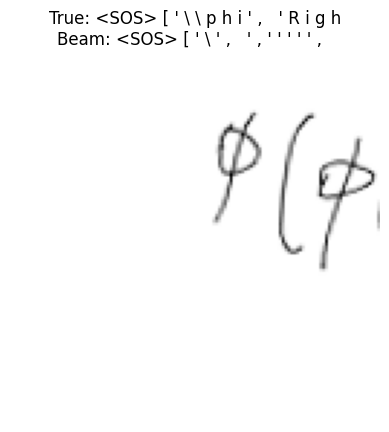

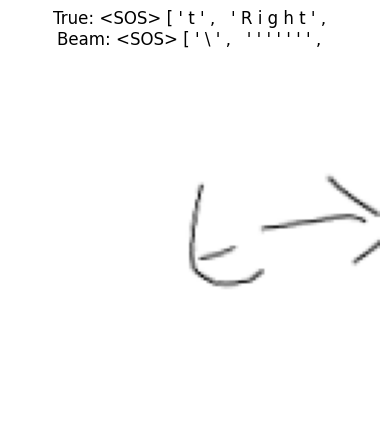

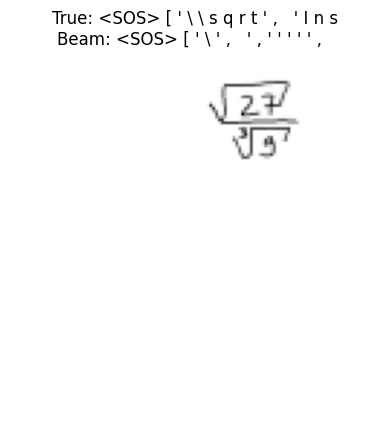

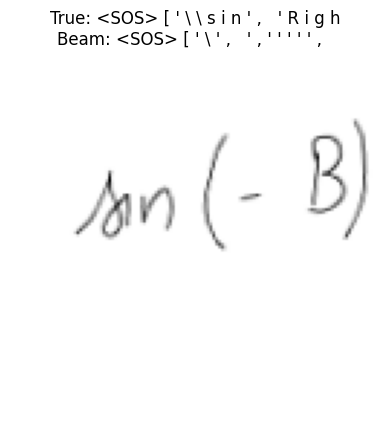

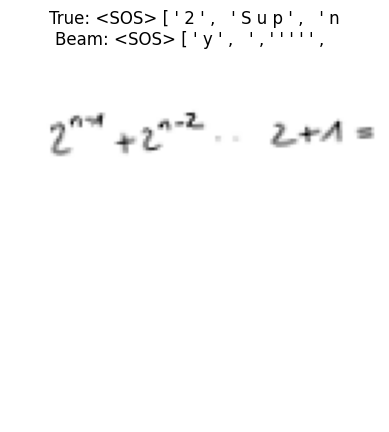

In [14]:
import numpy as np
import tensorflow as tf

# decode list of token ids
def decode_tokens(token_ids, id_to_token):
    return [id_to_token.get(int(tok), "<UNK>") for tok in token_ids if int(tok) != 0]

# beam search decoder
def beam_search_decoder(predictions, beam_width=3):
    # predictions: (timesteps, vocab_size)
    sequences = [[list(), 0.0]]  # (tokens, score)

    for t in range(predictions.shape[0]):
        all_candidates = []
        for seq, score in sequences:
            for i in range(predictions.shape[1]):
                candidate_seq = seq + [i]
                candidate_score = score - np.log(predictions[t, i] + 1e-9)
                all_candidates.append([candidate_seq, candidate_score])
        # sort and keep top-k sequences
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

    # return best sequence
    return sequences[0][0]

# preview predictions with beam search
def preview_with_beam(valid_dataset, model, id_to_token, num_samples=5, beam_width=3):
    for images, labels in valid_dataset.take(1):
        preds = model.predict(images)

        for i in range(num_samples):
            image = images[i].numpy().squeeze()
            label_ids = labels[i].numpy()
            true_label = decode_tokens(label_ids, id_to_token)

            pred_probs = preds[i]  # shape: (timesteps, vocab_size)
            pred_ids = beam_search_decoder(pred_probs, beam_width=beam_width)
            pred_label = decode_tokens(pred_ids, id_to_token)

            # display image and prediction
            import matplotlib.pyplot as plt
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.title(f"True: {' '.join(true_label)}\nBeam: {' '.join(pred_label)}")
            plt.show()
preview_with_beam(valid_dataset, model, id_to_token, num_samples=5, beam_width=3)
